In [ ]:
# !mkdir -p data
# !wget -O data/train.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar
# !wget -O data/test.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar
# !tar -xf data/train.tar -C data
# !tar -xf data/test.tar -C data

In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
from pathlib import Path
from typing import Optional
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
import torchvision
from torchvision import transforms

from utils.street_hazards import StreetHazardsDataset, StreetHazardsClasses, visualize_scene, visualize_annotation
from utils.misc import sliding_window_inference
from utils.eval import evaluate_model

from models.UNet import UNet
from models.utils import PretrainedSegmentationModel
from models.sigmoid_models import *

SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [92]:
# ds_train = StreetHazardsDataset("./data/train/train.odgt", patch_size=(144, 256))
# ds_val = StreetHazardsDataset("./data/train/validation.odgt")
# __ds_test = StreetHazardsDataset("./data/test/test.odgt")

# plt.figure(figsize=(12, 10))
# plt.subplot(3, 2, 1)
# visualize_scene(ds_train[0][0])
# plt.subplot(3, 2, 2)
# visualize_annotation(ds_train[0][1])
# plt.subplot(3, 2, 3)
# visualize_scene(ds_val[0][0])
# plt.subplot(3, 2, 4)
# visualize_annotation(ds_val[0][1])
# plt.subplot(3, 2, 5)
# visualize_scene(__ds_test[0][0])
# plt.subplot(3, 2, 6)
# visualize_annotation(__ds_test[0][1])
# plt.show()

In [ ]:
# def plot_class_distribution(ds, title="", scale="linear", num_classes=14):
#     classes_count = [0] * num_classes

#     for i in tqdm(range(len(ds))):
#         classes, counts = ds[i][1].unique(return_counts=True)
#         for j in range(len(classes)):
#             classes_count[classes[j]] += counts[j].item()

#     p = plt.barh(range(len(classes_count)), classes_count)
#     plt.title(title)
#     plt.xlabel(f"Count ({scale})")
#     plt.ylabel("Class")
#     plt.yticks(range(num_classes))
#     plt.xscale(scale)

In [ ]:
# plt.figure(figsize=(16, 5))

# plt.subplot(1, 3, 1)
# plot_class_distribution(ds_train, title="Train", scale="log")
# plt.subplot(1, 3, 2)
# plot_class_distribution(ds_val ,title="Validation", scale="log")
# plt.subplot(1, 3, 3)
# plot_class_distribution(__ds_test, title="Test", scale="log")
# plt.show()

torch.Size([3, 144, 256])


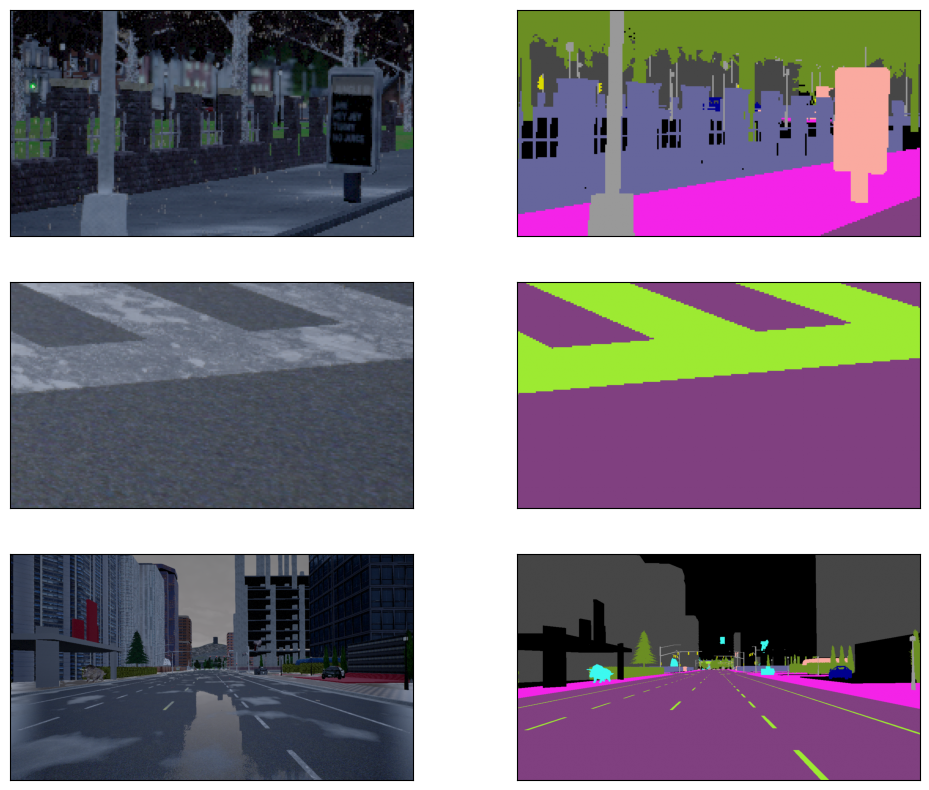

In [2]:
PATCH_SIZE = (144, 256)

ds_train = StreetHazardsDataset("./data/train/train.odgt", patch_size=PATCH_SIZE)
ds_val = StreetHazardsDataset("./data/train/validation.odgt", patch_size=PATCH_SIZE)
__ds_test = StreetHazardsDataset("./data/test/test.odgt")
ds_train = torch.utils.data.Subset(ds_train, np.random.default_rng(SEED).choice(range(len(ds_train)), size=1000, replace=False))
ds_val = torch.utils.data.Subset(ds_val, np.random.default_rng(SEED).choice(range(len(ds_val)), size=200, replace=False))
__ds_test = torch.utils.data.Subset(__ds_test, np.random.default_rng(SEED).choice(range(len(__ds_test)), size=200, replace=False))

print(ds_train[0][0].shape)

plt.figure(figsize=(12, 10))
plt.subplot(3, 2, 1)
visualize_scene(ds_train[0][0])
plt.subplot(3, 2, 2)
visualize_annotation(ds_train[0][1])
plt.subplot(3, 2, 3)
visualize_scene(ds_val[0][0])
plt.subplot(3, 2, 4)
visualize_annotation(ds_val[0][1])
plt.subplot(3, 2, 5)
visualize_scene(__ds_test[0][0])
plt.subplot(3, 2, 6)
visualize_annotation(__ds_test[0][1])
plt.show()

In [4]:
L.seed_everything(SEED, workers=True, verbose=False)
model = SigmoidModel(PretrainedSegmentationModel("deeplabv3_mobilenet"), { "lr": 3e-4, "weight_decay": 0.01 })

L.seed_everything(SEED, workers=True, verbose=False)

trainer = L.Trainer(
    max_epochs = 20,
    logger = False,
    enable_checkpointing = True,
    deterministic = True,
    callbacks = [
        ModelCheckpoint(dirpath="checkpoints", save_top_k=1, monitor="val_miou", mode="max")
    ]
)


trainer.fit(
    model, 
    DataLoader(ds_train, batch_size=16, shuffle=True, num_workers=2),
    DataLoader(ds_val, batch_size=16, shuffle=False, num_workers=2),
)

model.load_state_dict(torch.load(trainer.checkpoint_callback.best_model_path)["state_dict"])

print( "Val", evaluate_model(model, ds_val, device=DEVICE, compute_ap=False) )
print( "Test (no sw)", evaluate_model(model, __ds_test, device=DEVICE, patch_size=None) )
print( "Test (sw)", evaluate_model(model, __ds_test, device=DEVICE, patch_size=PATCH_SIZE) )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type                        | Params | Mode 
---------------------------------------------------------------------------
0 | segmentation_model | PretrainedSegmentationModel | 11.0 M | train
---------------------------------------------------------------------------
11.0 M    Trainable params
0         Non-trainable params
11.0 M    Total params
44.094    Total estimated model params size (MB)
283       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 --- train_loss: 2.47783 | train_miou: 0.54382 | val_loss: 3.50778 | val_miou: 0.48941


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 --- train_loss: 1.39097 | train_miou: 0.53145 | val_loss: 2.07521 | val_miou: 0.45766


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 --- train_loss: 0.68241 | train_miou: 0.74031 | val_loss: 1.48131 | val_miou: 0.54565


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 --- train_loss: 0.86327 | train_miou: 0.72153 | val_loss: 1.29244 | val_miou: 0.55553


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 --- train_loss: 1.97419 | train_miou: 0.29925 | val_loss: 1.10779 | val_miou: 0.59777


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 --- train_loss: 0.95742 | train_miou: 0.81563 | val_loss: 0.92129 | val_miou: 0.62118


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 --- train_loss: 0.77613 | train_miou: 0.79229 | val_loss: 1.03612 | val_miou: 0.60292


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 --- train_loss: 0.83740 | train_miou: 0.52617 | val_loss: 0.85102 | val_miou: 0.63447


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 --- train_loss: 0.43131 | train_miou: 0.62175 | val_loss: 0.85479 | val_miou: 0.64769


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 --- train_loss: 0.64844 | train_miou: 0.83332 | val_loss: 0.77663 | val_miou: 0.65546


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10 --- train_loss: 0.45871 | train_miou: 0.60631 | val_loss: 0.76569 | val_miou: 0.65424


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11 --- train_loss: 0.59928 | train_miou: 0.61350 | val_loss: 0.76502 | val_miou: 0.65722


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12 --- train_loss: 0.45967 | train_miou: 0.66028 | val_loss: 0.73778 | val_miou: 0.65974


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13 --- train_loss: 0.57171 | train_miou: 0.54005 | val_loss: 0.72610 | val_miou: 0.66734


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14 --- train_loss: 0.36082 | train_miou: 0.89093 | val_loss: 0.82300 | val_miou: 0.64526


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15 --- train_loss: 0.67401 | train_miou: 0.49206 | val_loss: 0.75505 | val_miou: 0.66300


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16 --- train_loss: 0.21634 | train_miou: 0.72156 | val_loss: 0.78209 | val_miou: 0.65699


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17 --- train_loss: 0.48338 | train_miou: 0.67426 | val_loss: 0.88418 | val_miou: 0.63102


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18 --- train_loss: 0.28850 | train_miou: 0.90531 | val_loss: 0.88034 | val_miou: 0.64398


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19 --- train_loss: 0.22335 | train_miou: 0.77575 | val_loss: 0.75972 | val_miou: 0.66545


  0%|          | 0/200 [00:00<?, ?it/s]

Val {'miou': {'mean': 0.667357830607798, 'std': 0.37160632930013726}, 'ap': None}


  0%|          | 0/200 [00:00<?, ?it/s]

Test (no sw) {'miou': {'mean': 0.5483564947545528, 'std': 0.10325023378671679}, 'ap': {'mean': 0.027729135611880337, 'std': 0.03323054171664022}}


  0%|          | 0/200 [00:00<?, ?it/s]

Test (sw) {'miou': {'mean': 0.7148606818914414, 'std': 0.09158267960188532}, 'ap': {'mean': 0.06440665511094266, 'std': 0.07501639998778191}}


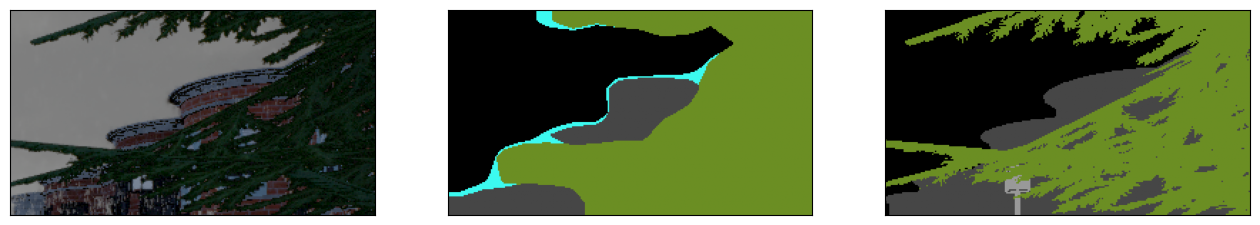

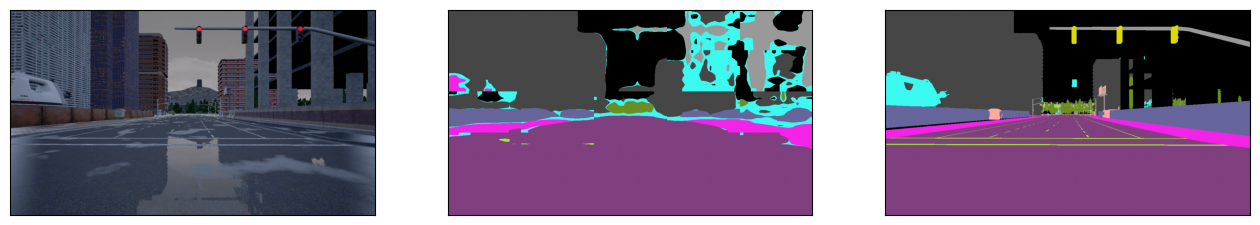

In [5]:
sample = ds_val[10]

model.eval().cuda()
with torch.no_grad():
    out = sliding_window_inference(model, sample[0], PATCH_SIZE, "cuda")
segm = torch.argmax(out, axis=0)

plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
visualize_scene(sample[0].cpu())
plt.subplot(1, 3, 2)
visualize_annotation(segm.cpu())
plt.subplot(1, 3, 3)
visualize_annotation(sample[1])
plt.show()


sample = __ds_test[15]

model.eval()
with torch.no_grad():
    out = sliding_window_inference(model, sample[0], PATCH_SIZE, "cuda")
segm = torch.argmax(out, axis=0)

plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
visualize_scene(sample[0].cpu())
plt.subplot(1, 3, 2)
visualize_annotation(segm.cpu())
plt.subplot(1, 3, 3)
visualize_annotation(sample[1])
plt.show()